# Single column matrix input file. IWP variation.

Preparing matrix of 1D columns .nc file and formatting for input ecRad file (Useful for TripleClouds Solver).

Version 6: 2023-07-17

Fixed parameters:

1. Radiative Transfer Model: ecRad
2. Cosine of solar zenith angle: $\mu = 0.6$ (effective solar zenith angle of $53^{\circ}$, Wallace&Hobbs, 2006).
3. SW albedo: $\alpha = 0.05$ (Hartmann & Berry, 2017).
4. LW emissivity: $\epsilon = 0.97$ (REFERENCE?).
5. Skin temperature as surface temperature: $T_{skin} = 300 K$ (290 to 300 K (Jin & Dickinson, 2010)).
6. No gases and aerosols.
7. No liquid water.
8. Tropical Sounding Climatology (Temperature, Pressure and Specific Humidity) (Lapse Rate of $6.7\;K/km$ (see "1D_ecrad_input_creator_height_v6.ipynb")).

Variable parameters:
1. Macro: Temperature (Altitude-position) = 236 K, 218 K and 201 K for cloud middle level.
2. Macro: Geometrical Depth $\Delta h = 1.5 km$.
3. Macro: Ice Water Path (IWP) = 0.1:0.1:1000 $g/m^2$ (Sokol & Hartmann 2020):

    $$IWP \;=\; \int{IWC\;dz} \;=\; \int_{h_1}^{h_2}{q_i\;\rho(z)\;dz}\;\;\; , \;\;\;(h_2 - h_1 = 1.5 \;km)$$

    where IWC is the Ice Water Content $(g/m^3)$, which is the Ice Water Mixing Ratio $q_{i}\;(g/km)$ times the density $\rho(z)$:

    $$\Rightarrow\;q_i = \frac{IWP}{\int_{h_1}^{h_2}{\rho(z)\;dz}}$$

4. Micro: Effective Radius $r_e$ = 30 $\mu m$ (Hartmann & Berry, 2017).
5. Ice Optical Schemes:

    5.1 Fu 1996 and Fu, Yang & Sun 1998 (1O).
    
    5.2 Yi et al. 2013 (2O).
    
    5.3 Baran et al. 2016 (3O).
    
    5.4 Baran et al. 2014 (4O).
    
    
6. Solvers: Tripleclouds

## Loading Libraries

Version list:

1. xarray : 2022.11.0
2. numpy : 1.23.4
4. matplotlib : 3.6.2

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

## Loading Data

In [2]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_7331/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [3]:
temp            = tropical_profile['temperature (K)'].iloc[::-1]
height          = tropical_profile['height (km)'].iloc[::-1]
tropopause_i    = temp.argmin()
tropopause      = temp.iloc[tropopause_i]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]

print('Tropopause: ',tropopause,' K at ',height.iloc[tropopause_i],' km')
print('Melting Layer: ',height.iloc[melting_layer_i],' km')

Tropopause:  195.6  K at  17.0  km
Melting Layer:  4.75  km


See "1D_ecrad_input_creator_height_v6.ipynb" for tropical sounding figures

## Preparing input

List of parameters:

- Skin Temperature (for each temperature)
- cos_solar_zenith_angle (for each temperature)
- pressure_hl (half level column)
- temperature_hl (half level column)
- q or h2o_mmr (Specific Humidity) (level column)
- o3_mmr (Ozone Mass Mixing Ratio) (level column)
- q_liquid (Liquid cloud mass mixing ratio (kg kg-1)) (level column)
- q_ice (Ice cloud mass mixing ratio (kg kg-1)) (level column)
- re_liquid (m) (level column)
- re_ice (m) (level column)
- cloud_fraction (level column)
- sw_albedo (1 value)
- lw_emissivity (1 value)
- aerosol_mmr (matrix)

### 1. Density Profile $(kg/m^3)$

In [4]:
R       = 287 # J/kgK
density = (tropical_profile['pressure (hPa)']*100)/(tropical_profile['temperature (K)']*R)
density = density.iloc[::-1]

### 2. Half Level Pressures (Pa)

"The half_level dimension corresponds to the mid-points of the levels, plus the top-of-atmosphere and surface, and so must be one more than level"

In [5]:
pressure_hli = [tropical_profile['pressure (hPa)'].iloc[-1]*100] # Pa
for i in range(len(tropical_profile['pressure (hPa)'])-1):
    pif = tropical_profile['pressure (hPa)'].iloc[-1-(i+1)]*100
    pii = tropical_profile['pressure (hPa)'].iloc[-1-i]*100
    pressure_hli.append((pif+pii)/2)
pressure_hli.append(tropical_profile['pressure (hPa)'].iloc[0]*100) # Pa

### 3. Half Level Temperatures (K)

Interpolation obtained from half level pressures:

In [6]:
temp_int        = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                       tropical_profile['temperature (K)'].iloc[::-1])
temperature_hli = temp_int(pressure_hli)

### 4. Matrix

IWP from .1 to 1000 every .1 $g/m^2$ # For Logarithmic display

In [7]:
iwp  = np.arange(.1,1000.1,.1)
rows = len(iwp)
print(rows)

10000


Level of perturbation (236 K, 218 K, 201 K) with 1.5 km cloud depth:

In [8]:
# Fixed parameters:
cos_solar_zenith_angle = np.full(rows, .6)
lw_emissivity          = np.full(rows, .97)
sw_albedo              = np.full(rows, .05)
skin_temperature       = np.full(rows, temp.iloc[-1]) # 300 K from surface temperature [K]

re = 30 # Effective radious [um]

# Specific humidity matrix (perturbations X level):
qi = tropical_profile['specific hum\t(kg/kg)'].iloc[::-1]
q  = np.full((rows,len(pressure_hli)-1),qi)

# Ozone mass mixing ratio matrix (perturbations X level):
o3_mmr = np.zeros((rows,len(pressure_hli)-1))

# Liquid cloud mass mixing ratio (perturbations X level):
q_liquid = np.zeros((rows,len(pressure_hli)-1))

# Liquid cloud effective radius (m):
re_liquid = np.full((rows,len(pressure_hli)-1),1e-5)

# Ice cloud effective radius (m):
re_ice = np.full((rows,len(pressure_hli)-1),re*1e-6)

# Half Level Pressures (perturbations X half_level):
pressure_hl = np.full((rows,len(pressure_hli)),pressure_hli)

# Half Level Temperatures (perturbations X half_level):
temperature_hl = np.full((rows,len(pressure_hli)),temperature_hli)

# CREATING THE ICE WATER MIXING RATIO PROFILE FOR EACH PERTURBATION LEVEL:
perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:
    # Ice cloud mass mixing ratio (perturbations X level):
    globals()['q_ice_'+str(pert_tempi)]          = np.zeros((rows,len(pressure_hli)-1))
    globals()['cloud_fraction_'+str(pert_tempi)] = np.zeros((rows,len(pressure_hli)-1))
    
    perturbation_i      = (temp.iloc[tropopause_i:] - pert_tempi).abs().argmin() # iloc position
    perturbation_height = height.iloc[tropopause_i+perturbation_i]
    # loc position: lower_limit_hi = height[height==(perturbation_height - .75)].index[0]
    # loc position: upper_limit_hi = height[height==(perturbation_height + .75)].index[0]
    # iloc position of bottom layer:
    bottom_hi = height.index.get_loc(height[height == (perturbation_height - .75)].index[0])
    # iloc position of top layer:
    top_hi    = height.index.get_loc(height[height == (perturbation_height + .75)].index[0])
    
    # Integration layer (or cloud position for 1.5 km depth) from TOP to BOTTOM:
    integral  = abs(np.trapz(density.iloc[top_hi:bottom_hi+1],
                             height.iloc[top_hi:bottom_hi+1]*1000, 0.1))
    
    for i in range(rows): # columns with vertical profiles ("level" dimension for final matrix)
        qi = (iwp[i] / integral)*1e-3 # qi = IWP / int(rho dz) [kg/kg]
        for j in range(len(height)):
            if j >= tropopause_i:
                hj = height.iloc[j]
                if hj >= (perturbation_height - .75) and hj <= (perturbation_height + .75):
                        eval('q_ice_'+str(pert_tempi))[i,j]          = qi
                        eval('cloud_fraction_'+str(pert_tempi))[i,j] = 1

<IPython.core.display.Javascript object>


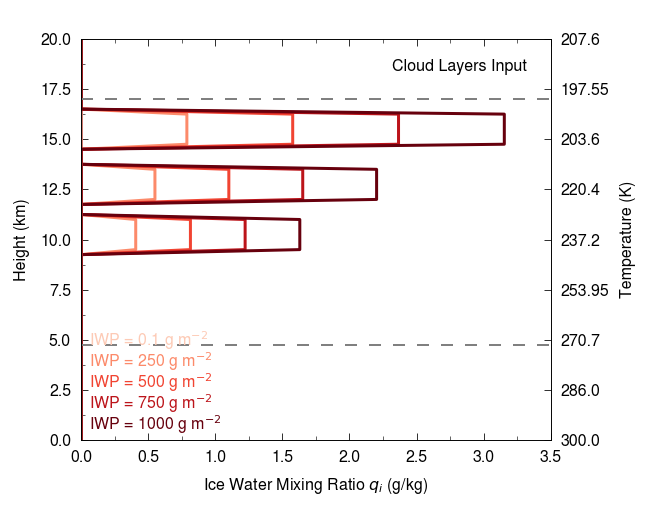

In [9]:
fontname  = 'Nimbus Sans'
#my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
#             (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
#             (169/255,23/255,38/255),
#             (116/255,24/255,123/255), 'grey']
fontsize  = 16
flength   = 9          # inches
fheigth   = flength*.8 # inches

f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.125, right = 0.85)

perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    for i in np.append(np.arange(0, rows, 2500), 9999):
        h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[i]*1000, 
                     tropical_profile['height (km)'].iloc[::-1],
                     linestyle = 'solid', linewidth = 3,
                     color = matplotlib.cm.Reds(.2 + counter*.2))
        counter += 1
        handles = handles + h1
        if i == 0: iwpi = str(iwp[i].round(1))
        else: iwpi = str(int(iwp[i].round(0)))
        labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.5, 4, .5)
minor_ticks_x = np.arange(-.5, 4, .25)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, 3.5)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.03, -.025),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_iwp_profiles_v6b.png', dpi = 500)

#### Separated IWP cloud layer figure for seminar

<IPython.core.display.Javascript object>


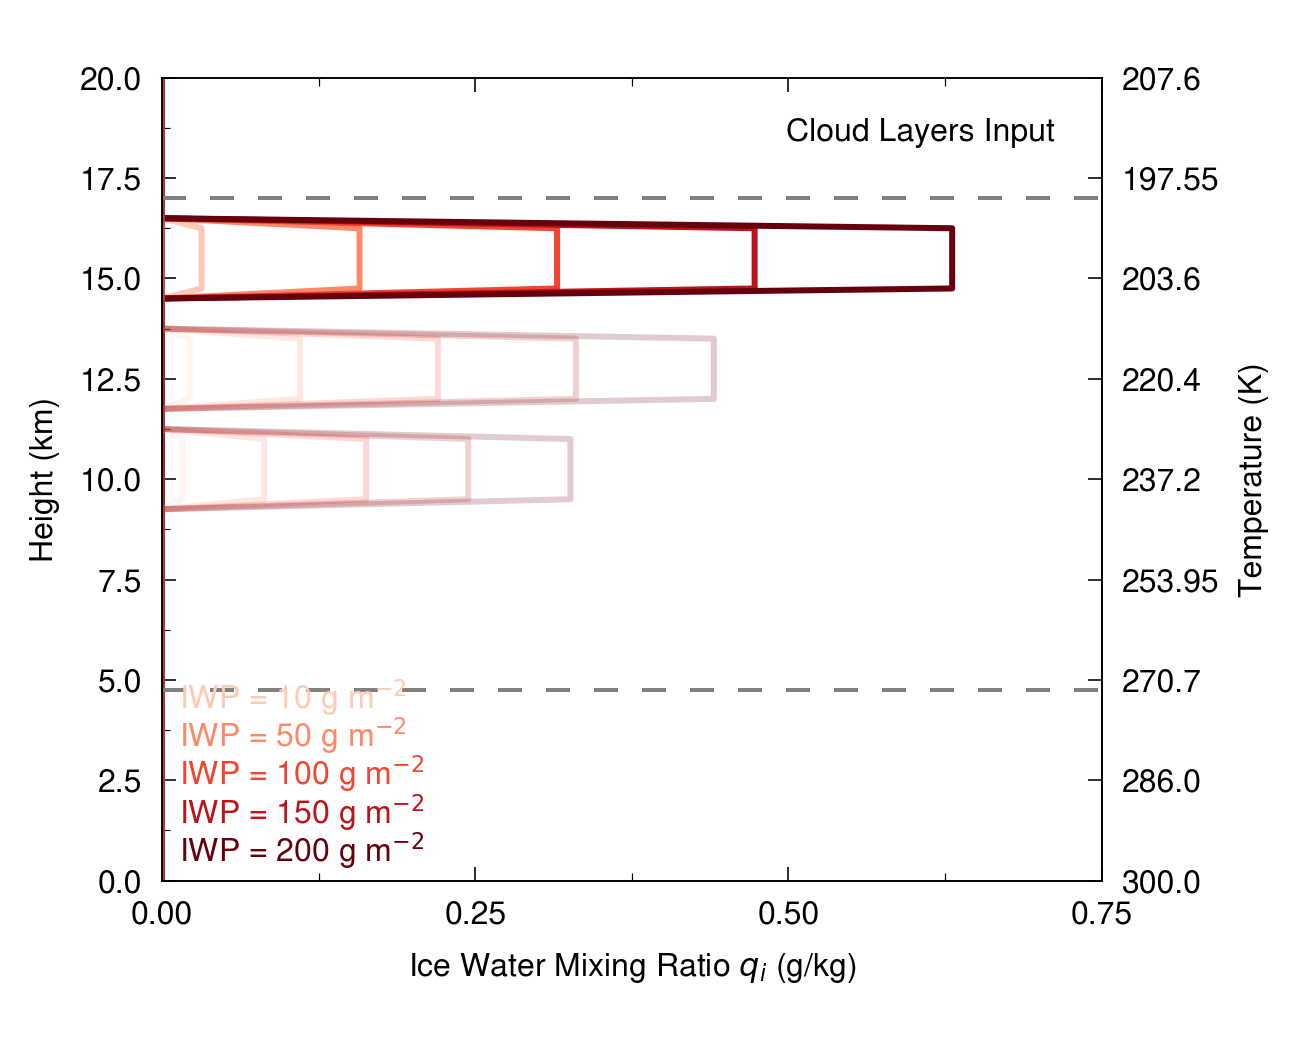

In [42]:
fontname  = 'Nimbus Sans'
#my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
#             (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
#             (169/255,23/255,38/255),
#             (116/255,24/255,123/255), 'grey']
fontsize  = 16
flength   = 9          # inches
fheigth   = flength*.8 # inches

f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.125, right = 0.85)

perturbations_temp = [201,218,236]#[236, 218, 201]
alpha = 1
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    if perturbations_temp.index(pert_tempi) > 0: alpha = 0.2
    for i in [99,499,999,1499,1999]:#[99]#[99,499]#[99,499,999]#[99,499,999,1499]#[99,499,999,1499,1999]
        h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[i]*1000, 
                     tropical_profile['height (km)'].iloc[::-1],
                     linestyle = 'solid', linewidth = 3,
                     color = matplotlib.cm.Reds(.2 + counter*.2),
                    alpha = alpha)
        counter += 1
        handles = handles + h1
        if i == 0: iwpi = str(iwp[i].round(1))
        else: iwpi = str(int(iwp[i].round(0)))
        labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.5, 4, .25)
minor_ticks_x = np.arange(-.5, 4, .125)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .75)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.03, -.025),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_iwp_profiles_v6.png', dpi = 500)

#### Separated IWP cloud layer figure for Supplementary material

In [23]:
q_ice_201[-1]*1000

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       3.15366674, 3.15366674, 3.15366674, 3.15366674, 3.15366674,
       3.15366674, 3.15366674, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

<IPython.core.display.Javascript object>


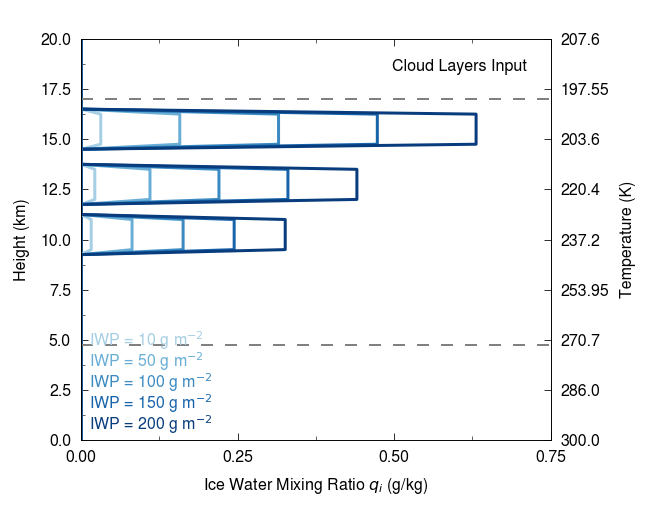

In [16]:
fontname  = 'Nimbus Sans'
#my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
#             (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
#             (169/255,23/255,38/255),
#             (116/255,24/255,123/255), 'grey']
fontsize  = 16
flength   = 9          # inches
fheigth   = flength*.8 # inches

f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.125, right = 0.85)

perturbations_temp = [201,218,236]#[236, 218, 201]
alpha = 1
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    #if perturbations_temp.index(pert_tempi) > 0: alpha = 1
    for i in [99,499,999,1499,1999]:#[99]#[99,499]#[99,499,999]#[99,499,999,1499]#[99,499,999,1499,1999]
        h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[i]*1000, 
                     tropical_profile['height (km)'].iloc[::-1],
                     linestyle = 'solid', linewidth = 3,
                     color = matplotlib.cm.Blues(.35 + counter*.15),
                    alpha = alpha)
        counter += 1
        handles = handles + h1
        if i == 0: iwpi = str(iwp[i].round(1))
        else: iwpi = str(int(iwp[i].round(0)))
        labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.5, 4, .25)
minor_ticks_x = np.arange(-.5, 4, .125)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .75)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.03, -.025),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_iwp_profiles_v6.png', dpi = 500)

#### Checking at IWP = 30 $g m^{-2}$

<IPython.core.display.Javascript object>


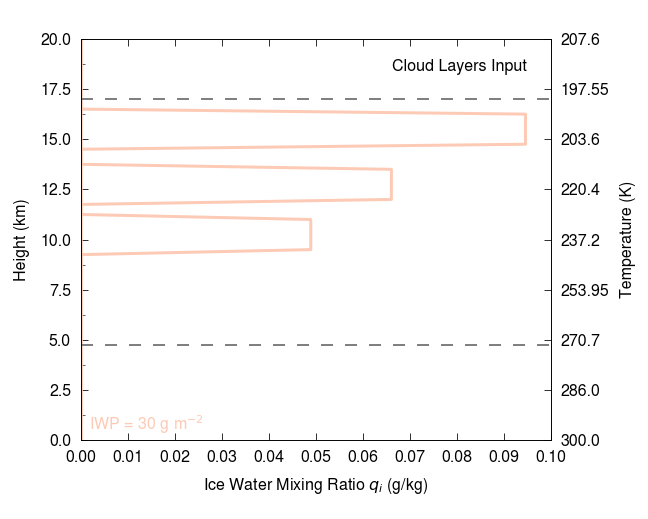

In [17]:
fontname  = 'Nimbus Sans'
#my_colors = [(107/255,188/255,233/255), (88/255,148/255,197/255), 
#             (131/255,170/255,69/255), (229/255,179/255,69/255), (202/255,91/255,46/255),
#             (169/255,23/255,38/255),
#             (116/255,24/255,123/255), 'grey']
fontsize  = 16
flength   = 9          # inches
fheigth   = flength*.8 # inches

f, ax     = plt.subplots(figsize = (flength, fheigth), dpi=72)
plt.subplots_adjust(top = 0.925, bottom = 0.15, left =0.125, right = 0.85)

perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:
    handles = []
    labels  = []
    counter = 0
    h1 = ax.plot(eval('q_ice_'+str(pert_tempi))[299]*1000, 
                 tropical_profile['height (km)'].iloc[::-1],
                 linestyle = 'solid', linewidth = 3,
                 color = matplotlib.cm.Reds(.2 + counter*.2))
    counter += 1
    handles = handles + h1
    iwpi = str(int(iwp[299].round(0)))
    labels.append('IWP = ' + iwpi + r' g m$^{-2}$')
        
melting_layer_h = tropical_profile['height (km)'].iloc[::-1].iloc[melting_layer_i]
h2 = ax.axhline(y = melting_layer_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)
tropopause_h = tropical_profile['height (km)'].iloc[::-1].iloc[tropopause_i]
h3 = ax.axhline(y = tropopause_h, linestyle = 'dashed', color = 'grey',
                dashes = (6, 6), linewidth  =2)

#ax.grid('on', linestyle = 'dashed', color = 'grey',
#        dashes = (25, 25), linewidth = .3)

# X Axis:
ax.set_xlabel(r'Ice Water Mixing Ratio $q_{i}$ (g/kg)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_x = np.arange(-.2, .2, .01)
minor_ticks_x = np.arange(-.2, .2, .01)
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_xlim(0, .1)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad=10)
ax.tick_params(axis = 'x', which = 'major', color = 'black',
               size = 7, direction = 'in', top = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'x', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_xticklabels():
    tick.set_fontname(fontname)

# Y Axis:
ax.set_ylabel('Height (km)', 
              fontname = fontname, fontsize = fontsize,
              color = 'black', labelpad = 10)
major_ticks_y = np.arange(-20, 30, 2.5)
minor_ticks_y = np.arange(-20, 30, 1.25)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_ylim(0, 20)
ax.tick_params(axis = 'y', which = 'major', color = 'black',
               size = 7, direction = 'in', right = True,
               labelsize = fontsize, pad = 10)
ax.tick_params(axis = 'y', which = 'minor',
               color = 'black', size = 4,
               direction = 'in', top = True)
for tick in ax.get_yticklabels():
    tick.set_fontname(fontname)
#ax.tick_params(axis = 'y', which = 'minor', color = 'black',
#               size = 4, direction = 'in', right = True)

# Right Y Axis:
ax2 = ax.twinx()
ax2.set_ylabel('Temperature (K)',
               fontname = fontname, fontsize = fontsize,
               color = 'black', labelpad = 10)
yticklabels1 = np.arange(0, 22.5, 2.5) # default altitude tick labels
yticklabels2 = tropical_profile['temperature (K)'].loc[tropical_profile['height (km)'].isin(yticklabels1)].to_list()    
ax2.set_yticks(yticklabels1)
ax2.set_yticklabels(yticklabels2)
ax2.tick_params(axis = 'y', which = 'major', color = 'black',
                size = 7, direction = 'in', right = True,
                labelsize = fontsize, pad = 10)
ax2.tick_params(axis = 'x', which = 'minor',
                color = 'black', size = 4,
                direction = 'in', top = True)
for tick in ax2.get_yticklabels():
    tick.set_fontname(fontname)

ax.text(0.95, 0.95, 'Cloud Layers Input',
        fontname = fontname, fontsize = fontsize,
        color = 'black',
        ha = 'right', va = 'top', transform = ax.transAxes)

# Legend:
#handles = h1 + h2 + h3 + h4
#labels  = ['200 K','212 K','224 K','236 K']    
legend = plt.legend(handles, labels, loc = 'lower left', bbox_to_anchor = (-.03, -.025),
                    frameon = False, ncol = 1, columnspacing = 1,
                    labelspacing = -.1, labelcolor = 'linecolor',
                    handlelength = 0, handletextpad = .5,
                    prop = {'family': fontname, 'size': fontsize})

# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_qi_iwp_profiles_v6.png', dpi = 500)

### Final Tables

In [105]:
perturbations_temp = [236, 218, 201]
for pert_tempi in perturbations_temp:
    # Finish
    
    ds = xr.Dataset(
        data_vars = dict(
            #time = (time),
            iwp = (['column'], iwp),
            #longitude = (['column'], longitude),
            lw_emissivity = (['column'], lw_emissivity),
            sw_albedo = (['column'], sw_albedo),
            skin_temperature = (['column'], skin_temperature),
            cos_solar_zenith_angle = (['column'], cos_solar_zenith_angle),
            pressure_hl = (['column','half_level'], pressure_hl),
            temperature_hl = (['column','half_level'], temperature_hl),
            q = (['column','level'], q),
            o3_mmr = (['column','level'], o3_mmr),
            q_liquid = (['column','level'], q_liquid),
            q_ice = (['column','level'], eval('q_ice_' + str(pert_tempi))),
            re_liquid = (['column','level'], re_liquid),
            re_ice = (['column','level'], re_ice),
            cloud_fraction = (['column','level'], eval('cloud_fraction_' + str(pert_tempi))),
        ),
        attrs = dict(
            title="1D columns matrix input for ecRad"),
    )
    out_dir = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
    file    = 'input_1D_matrix_iwp_'+str(pert_tempi)+'_v6.nc'
    ds.to_netcdf(path = out_dir+file)